In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.isokann.modules3 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)


Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_trajectories5 = output/trajectories/openmm_files/final_states_nh/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [ ]:
# Load initial and final states and convert to torch
D0 = pt.load(out_trajectories1 + 'BAT_0.pt', map_location=device)
DT = pt.load(out_trajectories1 + 'BAT_t.pt', map_location=device)

Ra = np.loadtxt(out_trajectories1 + 'Ra.txt')
Rb = np.loadtxt(out_trajectories1 + 'Rb.txt')
Rc = np.loadtxt(out_trajectories1 + 'Rc.txt')

Sa = np.loadtxt(out_trajectories1 + 'Sa.txt')
Sb = np.loadtxt(out_trajectories1 + 'Sb.txt')

Npoints = D0.shape[0]
Ndims   = D0.shape[1]

Nfinpoints  = DT.shape[1]
Nframes     = DT.shape[3]


frame = 9
Dt = pt.clone(DT[frame,:,:,:])

print(Dt.shape)

torch.Size([6000, 10, 1716])


In [5]:
import pickle 

# Load from the file
with open(out_isokann + 'hyperparameters.pkl', 'rb') as file:
    best_hyperparams = pickle.load(file)


print("The best hyperparameters are:", best_hyperparams)

The best hyperparameters are: {'Nepochs': 15, 'nodes': array([1716,  858,  429,    1]), 'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 100, 'patience': 5, 'act_fun': 'leakyrelu'}


In [6]:
# Power method iterations
Niters    = 400

# NN hyperparameters
Nepochs   = best_hyperparams['Nepochs']
nodes     = best_hyperparams['nodes']
lr        = best_hyperparams['learning_rate']
wd        = best_hyperparams['weight_decay']
bs        = best_hyperparams['batch_size']
patience  = best_hyperparams['patience']
act_fun   = best_hyperparams['act_fun']


tolerance = 0.00001

# Define the interpolating function
f_NN = NeuralNetwork( Nodes = np.asarray(nodes) ).to(device)

npX0 = D0.cpu().detach().numpy()



# Apply the power method using the best hyperparameters
train_LOSS, val_LOSS, best_loss, convergence = power_method(D0,
                                                            Dt,
                                                            f_NN,
                                                            scale_and_shift,
                                                            Niters = Niters,
                                                            Nepochs = Nepochs,
                                                            tolerance  = tolerance,
                                                            lr = lr,
                                                            wd = wd,
                                                            batch_size = 1000,
                                                            patience = patience,
                                                            print_eta  = True,
                                                            test_size = 0.2,
                                                            loss = 'full'
                                                            )

chi  = f_NN(D0).cpu().detach().numpy()

 24%|██▍       | 95/400 [00:11<00:37,  8.16it/s]


Correlation with RMSD A: 0.1919712330307487
Correlation with RMSD B: -0.6302875432553617
Correlation with RMSD C: -0.8273255468944598
Correlation with segment A: -0.14776748928074457
Correlation with segment B: -0.8500163077910878
 
Canonical Correlation Coefficient: 0.8719291677754657


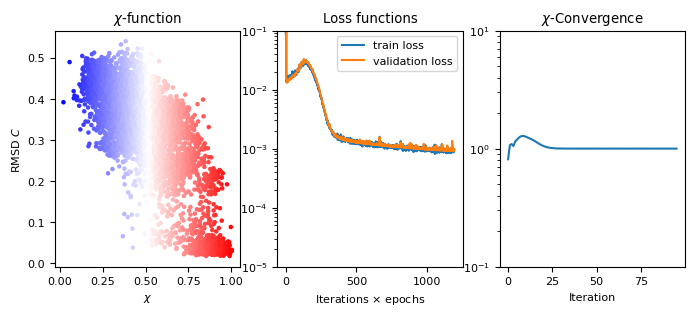

In [7]:
print('Correlation with RMSD A:', np.corrcoef(Ra, chi)[0,1])
print('Correlation with RMSD B:', np.corrcoef(Rb, chi)[0,1])
print('Correlation with RMSD C:', np.corrcoef(Rc, chi)[0,1])
print('Correlation with segment A:', np.corrcoef(Sa, chi)[0,1])
print('Correlation with segment B:', np.corrcoef(Sb, chi)[0,1])

print(" ")

from sklearn.cross_decomposition import CCA
X1 = np.column_stack((Ra, Rb, Rc))  # Shape: (n_samples, 2)
X2 = chi.reshape(-1, 1)           # Shape: (n_samples, 1)

# Initialize and fit CCA
cca = CCA(n_components=1)  # Use one component to capture 1D relationship
cca.fit(X1, X2)

# Transform data into canonical space
X1_c, X2_c = cca.transform(X1, X2)

# Results
print("Canonical Correlation Coefficient:", np.corrcoef(X1_c.T, X2_c.T)[0, 1])


# Figure

font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, ax = plt.subplots(1, 3, figsize=(16*in2cm, 6*in2cm), facecolor='white')


pos = ax[0].scatter( chi, Rc, c = chi,  cmap = cm.bwr , s = 5 )

ax[0].set_title('$\chi$-function')
#ax[0].set_xlim((0,1))
ax[0].set_ylabel(r'RMSD $C$')
ax[0].set_xlabel(r'$\chi$')


ax[1].plot(train_LOSS, label='train loss')
ax[1].plot(val_LOSS, label='validation loss')
ax[1].semilogy()
ax[1].set_xlabel(r'Iterations $\times$ epochs')
ax[1].set_title('Loss functions')
ax[1].legend()
ax[1].set_ylim(0.00001,0.1)

ax[2].plot(convergence)
ax[2].semilogy()
ax[2].set_xlabel('Iteration')
ax[2].set_title(r'$\chi$-Convergence')
ax[2].set_ylim(0.1,10)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.7)
fig.savefig("output/figures/isokann.png", format='png', dpi=300, bbox_inches='tight')

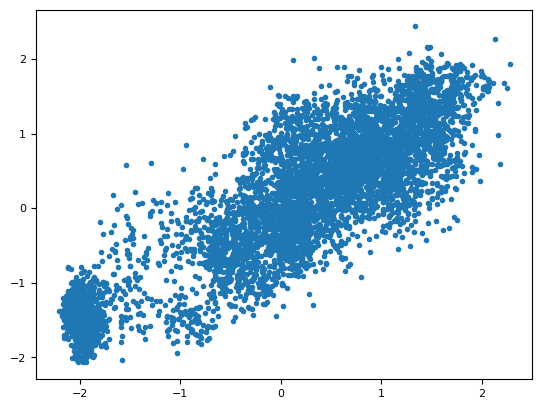

In [8]:
plt.plot(X1_c, X2_c, '.')

In [10]:
pt.save(f_NN.state_dict(), out_isokann  + 'f_NN.pt')
np.savetxt(out_isokann  + 'val_LOSS.txt', val_LOSS)
np.savetxt(out_isokann  + 'train_LOSS.txt', train_LOSS)
np.savetxt(out_isokann + 'chi0.txt', chi)

# Calculate propagated chi
#chit = f_NN(Xtau).cpu().detach().numpy()
#np.save(out_isokann + 'chit.npy', chit)
